<a href="https://colab.research.google.com/github/Kaiziferr/XGBoost/blob/main/04_check_xgboost_is_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

# **Info**
---


@By: Steven Bernal

@Nickname: Kaiziferr

@Git: https://github.com/Kaiziferr

# **Diccionario de datos**
---
- `Name`: time window name.
- `Netflows`: number of netflows in the time window.
- `First_Protocol`: top 1 of main protocols used in the time window.
- `Second_Protocol`: top 2 of main protocols used in the time window.
- `Third_Protocol`: top 3 of main protocols used in the time window.
- `p1_d`: 25% of the percentiles of all durations in the time window
- `p2_d`: 50% of the percentiles of all durations in the time window
- `p3_d`: 75% of the percentiles of all durations in the time window
- `duration`: total duration of time window
- `max_d`: maximum value of all durations within the time window.
- `min_d`: minium value of all durations within the time window.
- `#packets`: total number of packets in the time window.
- `Avg_bps`: average bits per second within the time window.
- `Avg_pps`: average packets per second within the time window.
- `Avg_bpp`: average bytes per second within the time window.
- `#Bytes`: ntotal number of bytes in the time window.
- `#sp`: total number of source ports used within the time window.
- `#dp`: total number of destination (end) ports used within the time window
- `first_sp`: top 1 of the source ports in the time window.
- `second_sp`: top 2 of the source ports in the time window.
- `third_sp`: top 3 of the source ports in the time window.
- `first_dp`: top 1 of the destination ports in the time window.
- `second_dp`: top 2 of the destination ports in the time window.
- `third_dp`: top 3 of the destination ports in the time window.
- `p1_ip`: 25% of the percentiles of all packet entries within the time window.
- `p2_ip`: 50% of the percentiles of all packet entries within the time window.
- `p3_ip`: 75% of the percentiles of all packet entries within the time window.
- `p1_ib`: 25% of the percentiles of all bytes entries within the time window.
- `p2_ib`: 50% of the percentiles of all bytes entries within the time window.
- `p3_ib`: 75% of the percentiles of all bytes entries within the time window.
- `Type`: cryptocurrency type
  - `benignas`: 0
  - `bitcash`: 1
  - `bitcoin`: 2
  - `ethereum `: 3
  - `monero`: 4
  - `litecoin`: 5

# **Config**

---



In [5]:
sns.set(style ='darkgrid')
pd.set_option('display.float_format', '{:,.2f}'.format)
title_data = 'Traffic Cryptocurrency'
paleta = sns.color_palette('Set2').as_hex()
random_seed = 73
warnings.filterwarnings("ignore")

#**Functions**
---

In [6]:
def plot_bar(data:pd.DataFrame, paleta:list=None, figsize_x:int=8, figsize_y:int=5,
             fontsize:int=15, **kwards)->None:
  """Grafica un diagrama de barras con multiples caracteristicas"""
  try:
    paleta = paleta if paleta !=None else sns.color_palette('Set2').as_hex()
    v = kwards
    ejeX = v["ejeX"]

    fig, ax = plt.subplots(figsize = (figsize_x, figsize_y))
    fig.suptitle(f'Diagrama de barras {v["title"]}', fontsize=fontsize)

    if type(ejeX) == str:
      sns.countplot(x=ejeX, data=data, ax = ax, palette=paleta)
    else:
      ejeX = v['ejeX'][0]
      sns.countplot(x=ejeX, hue=v['ejeX'][1], data=data, ax=ax, palette=paleta)

    ax.set_ylabel(v['ejey'], size = 12)
    ax.set_xlabel(ejeX, size=fontsize-3)
    ax.set_xticklabels(ax.get_xticklabels(),fontsize = fontsize-3)
    for p in ax.patches:
      try:
        height = int(p.get_height())
        ax.text(p.get_x()+p.get_width()/2., height + 1,height, ha="center")
      except:
        pass

  except Exception as e:
    print(e)

def sesgo_prediction(y_pred:pd.Series,
                     y_valid:pd.Series,
                     target:int)->tuple:
  """ Calcula el sesgo de predicción """
  average_prediction = (len(y_pred[y_pred==target])) / len(y_pred)
  average_label_target = (len(y_valid[y_valid==target])) / len(y_valid)
  sesgo_prediction = average_prediction - average_label_target
  return sesgo_prediction, average_prediction, average_label_target

# **Data**
---

In [7]:
url = 'https://raw.githubusercontent.com/Kaiziferr/datasets/main/cryptojacking.csv'
data = pd.read_csv(url, dtype=str).drop('Unnamed: 0', axis=1)

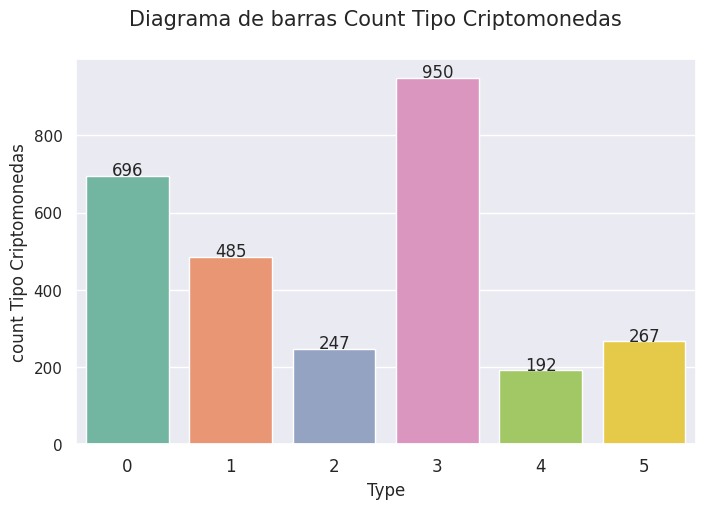

In [8]:
plot_bar(
    data,
    paleta=None,
    ejeX='Type',
    ejey='count Tipo Criptomonedas',
    title='Count Tipo Criptomonedas')

In [9]:
data.head()

,Name,Netflows,First_Protocol,Second_Protocol,Third_Protocol,p1_d,p2_d,p3_d,duration,max_d,...,first_dp,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type
0,0-csves/0.csv,65,TCP,UDP,NaN,18.939,168.173,194.287,7845.125999999999,244.362,...,443,80.0,123.0,3.0,7.0,22.0,127.0,255.0,1888.0,0
1,0-csves/1.csv,18,UDP,TCP,NaN,0.0,0.0,0.0,0.086,0.044,...,443,53.0,53195.0,1.0,1.0,1.0,37.0,47.0,64.0,0
2,1-csves/0.csv,10,UDP,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,53,39308.0,54454.0,1.0,1.0,1.0,34.0,43.0,61.75,0
3,1-csves/1.csv,2771,UDP,TCP,ICMP6,0.0,0.0,0.0,8548.902,149.034,...,53,5355.0,443.0,1.0,1.0,1.0,39.0,49.0,54.0,0
4,2-csves/0.csv,2,UDP,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,48871,53.0,NaN,1.0,1.0,1.0,37.0,41.0,45.0,0


**Change data type**

In [10]:
data[[
    'p1_d', 'p2_d', 'p3_d',
    'duration', 'max_d', 'min_d',
    'Avg_bps', 'Avg_pps','Avg_bpp',
    'p1_ip', 'p2_ip', 'p3_ip',
    'p1_ib', 'p2_ib','p3_ib']] = data[[
    'p1_d', 'p2_d', 'p3_d',
    'duration', 'max_d', 'min_d',
    'Avg_bps', 'Avg_pps','Avg_bpp',
    'p1_ip', 'p2_ip', 'p3_ip',
    'p1_ib', 'p2_ib','p3_ib']].astype('float64')


In [11]:
data[[
    'Netflows', '#packets',
    '#Bytes', '#sp', '#dp']] = data[[
    'Netflows', '#packets',
    '#Bytes', '#sp', '#dp']].astype('int64')

# **Data Split**
---

For the purposes of this exercise, I will use two categories of cryptocurrencies because I do not want to deal with the issue of imbalanced data at this time.

In [12]:
data = data[
    (data['Type'] == "2")
    |
    (data['Type'] == "5")]
data = data.reset_index()

While categorical variables could be used, for the purposes of this exercise, quantitative variables will be used.

In [13]:
X = data.select_dtypes(include=['float64', 'int64'])
y = data.iloc[:,-1]
le = LabelEncoder()
y = le.fit_transform(y)
X = X[['p1_d', 'p2_d', 'min_d', 'Avg_bpp', 'p1_ip', 'p2_ip', 'p3_ip', 'p2_ib']]

In [14]:
X

,p1_d,p2_d,min_d,Avg_bpp,p1_ip,p2_ip,p3_ip,p2_ib
0,114.79,180.04,114.74,394.00,10.00,12.50,15.00,"3,820.00"
1,196.18,196.19,196.18,469.00,10.50,11.00,11.50,"5,159.00"
2,244.14,244.14,244.14,425.00,16.00,16.00,16.00,"6,807.50"
3,244.05,244.05,244.05,419.00,16.00,16.00,16.00,"6,707.00"
4,246.79,246.79,246.79,376.00,17.75,18.50,19.25,"6,959.50"
...,...,...,...,...,...,...,...,...
509,2.16,4.32,0.00,424.00,1.25,1.50,1.75,636.50
510,583.37,583.81,582.93,336.00,53.50,55.00,56.50,"18,532.50"
511,288.55,288.55,288.55,318.00,22.25,22.50,22.75,"7,165.00"
512,285.38,285.38,285.38,329.00,24.75,25.50,26.25,"8,400.00"


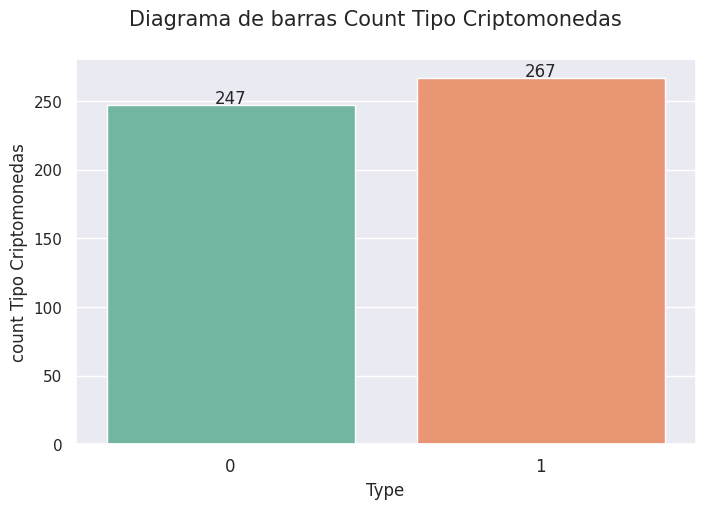

In [15]:
plot_bar(
    pd.concat([X, pd.Series(y, name='Type')], axis=1),
    paleta=None,
    ejeX='Type',
    ejey='count Tipo Criptomonedas',
    title='Count Tipo Criptomonedas')

I will simulate overfitting in the model reducing the test data.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.05,
    random_state = random_seed,
    shuffle=True,
    stratify=y
)

# **Model**
---

In [17]:
modelX = XGBClassifier(
    n_estimators = 100,
    learning_rate = 0.1,
    random_state = random_seed,
)

modelX.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=73, ...)

**Overfitting detection by a threshold difference.**


In [18]:
y_train_predict = modelX.predict(X_train)
y_test_predict = modelX.predict(X_test)

In [19]:
train_accuracy = accuracy_score(y_train, y_train_predict)
val_accuracy = accuracy_score(y_test, y_test_predict)

The model achieved an almost perfect score of 0.99 on the training data, while on the validation data it scored 0.84. This could be considered overfitting, as the performance on the test data is lower by nearly 15%.

In [20]:
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Training Accuracy: 0.9980
Validation Accuracy: 0.8462


In [21]:
train_accuracy - val_accuracy

0.15179697351828503

In [22]:
if (train_accuracy - val_accuracy) > 0.1:
  print("Warnings: The model may be overfitting!")

Warnings: The model may be overfitting!


**Learning curves for overfitting detection**

In [23]:
modelX

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=73, ...)

In [24]:
results = modelX.evals_result()
results.keys()

dict_keys(['validation_0', 'validation_1'])

Using the learning curves of the model, it is evident that for this model, with the given data configuration, the validation error curve is higher than the training error curve for each number of trees. There is no evidence of convergence at any point.

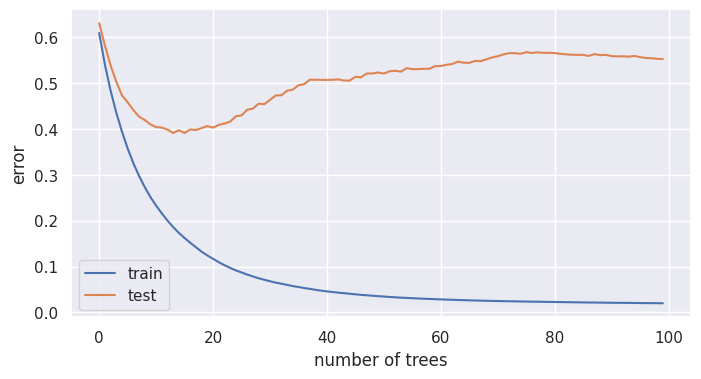

In [25]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(results['validation_0']['logloss'], label='train')
ax.plot(results['validation_1']['logloss'], label='test')
plt.xlabel('number of trees')
plt.ylabel('error')
plt.legend()
plt.show()

In [26]:
y_test

array([0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1])

In [27]:
y_train_predict

array([0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,

**Using prediction bias for overfitting detection**

It is evident that for the prediction of each class, the training bias is lower than the bias of the validation data. It could be said that the model exhibits bias in both classes.

In [28]:
sesgo, promedio_prediccion, promedio_validacion = sesgo_prediction(y_train_predict, y_test, 0)
print(f'Promedio de predicciones:  {promedio_prediccion*100}')
print(f'Promedio de etiquetas: {promedio_validacion*100}')
print(f'Sesgo de predicción: {sesgo*100}')

Promedio de predicciones:  47.950819672131146
Promedio de etiquetas: 46.15384615384615
Sesgo de predicción: 1.7969735182849889


In [29]:
sesgo, promedio_prediccion, promedio_validacion = sesgo_prediction(y_test_predict, y_test, 0)
print(f'Promedio de predicciones:  {promedio_prediccion*100}')
print(f'Promedio de etiquetas: {promedio_validacion*100}')
print(f'Sesgo de predicción: {sesgo*100}')

Promedio de predicciones:  53.84615384615385
Promedio de etiquetas: 46.15384615384615
Sesgo de predicción: 7.692307692307687


In [30]:
sesgo, promedio_prediccion, promedio_validacion = sesgo_prediction(y_train_predict, y_test, 1)
print(f'Promedio de predicciones:  {promedio_prediccion*100}')
print(f'Promedio de etiquetas: {promedio_validacion*100}')
print(f'Sesgo de predicción: {sesgo*100}')

Promedio de predicciones:  52.04918032786885
Promedio de etiquetas: 53.84615384615385
Sesgo de predicción: -1.7969735182849944


In [31]:
sesgo, promedio_prediccion, promedio_validacion = sesgo_prediction(y_test_predict, y_test, 1)
print(f'Promedio de predicciones:  {promedio_prediccion*100}')
print(f'Promedio de etiquetas: {promedio_validacion*100}')
print(f'Sesgo de predicción: {sesgo*100}')

Promedio de predicciones:  46.15384615384615
Promedio de etiquetas: 53.84615384615385
Sesgo de predicción: -7.692307692307687


@By: Steven Bernal

@Nickname: Kaiziferr

@Git: https://github.com/Kaiziferr